In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
import warnings 
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, LineString, Point
warnings.filterwarnings(action='ignore')

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import StandardScaler

In [3]:
plt.rcParams['font.family'] = 'Malgun Gothic'

## 경감지수 전처리

### 학교정보 및 상담 데이터

In [4]:
# 필요한 파일 출력
df_1 = pd.read_csv('서울시고등학교_교육여건_상담.csv', encoding='cp949')
df_2 = pd.read_csv('서울시고등학교_기본정보.csv', encoding='cp949')
df_3 = pd.read_csv('경찰청_경찰관서 위치.csv', encoding='cp949')

In [5]:
print(df_1.info())
print(df_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   구                       320 non-null    object 
 1   학교명                     320 non-null    object 
 2   학교코드                    320 non-null    object 
 3   내부상담_실시여부               320 non-null    int64  
 4   외부상담_실시여부               320 non-null    int64  
 5   wee클래스_운영여부             320 non-null    int64  
 6   학교폭력_예방교육_평균교육시간(1학급당)  320 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 17.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   지역              320 non-null    object 
 1   학교코드            320 non-null    object 
 2   학교명             320 non-null    object 
 3   설립구분            

In [6]:
# 학교 기본정보 + 교육여건_상담 데이터 병합
df_2 = df_2[['학교코드','위도','경도','법정동코드']]
school = pd.merge(df_1, df_2, on='학교코드', how='left')
school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   구                       320 non-null    object 
 1   학교명                     320 non-null    object 
 2   학교코드                    320 non-null    object 
 3   내부상담_실시여부               320 non-null    int64  
 4   외부상담_실시여부               320 non-null    int64  
 5   wee클래스_운영여부             320 non-null    int64  
 6   학교폭력_예방교육_평균교육시간(1학급당)  320 non-null    float64
 7   위도                      320 non-null    float64
 8   경도                      320 non-null    float64
 9   법정동코드                   320 non-null    int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 27.5+ KB


In [7]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   청       274 non-null    object 
 1   서       274 non-null    object 
 2   지구대파출소  274 non-null    object 
 3   X좌표     274 non-null    float64
 4   Y좌표     274 non-null    float64
dtypes: float64(2), object(3)
memory usage: 10.8+ KB


In [8]:
Police_station = df_3.rename({'X좌표':'경도','Y좌표':'위도'},axis=1)
Police_station

,청,서,지구대파출소,경도,위도
0,서울청,서울강남경찰서,논현1파출소,127.029316,37.513791
1,서울청,서울강남경찰서,논현2파출소,127.033875,37.515220
2,서울청,서울강남경찰서,삼성1파출소,127.060440,37.514852
3,서울청,서울강남경찰서,삼성2파출소,127.048063,37.511289
4,서울청,서울강남경찰서,서울강남경찰서,127.067177,37.509036
...,...,...,...,...,...
269,서울청,서울혜화경찰서,종로5가파출소,127.001606,37.570727
270,서울청,서울혜화경찰서,창신파출소,127.013702,37.578482
271,서울청,서울혜화경찰서,혜화파출소,127.001422,37.586135
272,서울청,서울혜화경찰서,효제파출소,127.003606,37.574259


### 학교 500m 내 경찰관서수

In [9]:
from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook

from haversine import haversine

In [10]:
def close_ps(school, Police_station, column) : 
    for i in tqdm(range(len(school))) : 
        distance = [] 
        for j in range(len(Police_station)) : 
            schoolloc = tuple(school[['경도','위도']].iloc[i])
            Police_stationloc = tuple(Police_station[['경도','위도']].iloc[j])
            distance.append(haversine(schoolloc, Police_stationloc, unit = 'm'))
            
        distance = [d for d in distance if d <= 500] 
        school[column][i] = len(distance)
        
    return school

In [11]:
school["500미터내_파출소개수"] = 0
school = close_ps(school, Police_station, "500미터내_파출소개수")

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [01:25<00:00,  3.76it/s]


In [12]:
school.groupby('500미터내_파출소개수').count()

,구,학교명,학교코드,내부상담_실시여부,외부상담_실시여부,wee클래스_운영여부,학교폭력_예방교육_평균교육시간(1학급당),위도,경도,법정동코드
500미터내_파출소개수,,,,,,,,,,
0,165,165,165,165,165,165,165,165,165,165
1,121,121,121,121,121,121,121,121,121,121
2,30,30,30,30,30,30,30,30,30,30
3,4,4,4,4,4,4,4,4,4,4


In [13]:
school.to_csv('경감지수_전처리.csv', index=False)

## 구별 CCTV 대수 데이터

In [14]:
CCTV = pd.read_csv('서울시 CCTV 설치운영 현황(자치구)-목적별.csv',encoding='cp949', thousands = ',')
CCTV

,구분,총계,방범,어린이\n보호구역,공원·놀이터,쓰레기\n무단투기,시설안전·화재예방,교통단속,교통정보수집·분석,기타다른법령
0,종로구,1729,1360,41,109,0,110,109,0,0
1,중구,2001,1180,75,165,62,62,290,8,159
2,용산구,2383,1740,164,154,0,0,252,0,73
3,성동구,3515,2834,0,177,151,15,338,0,0
4,광진구,2556,2011,301,98,71,5,70,0,0
5,동대문,2315,1682,282,174,28,1,134,0,14
6,중랑구,3285,2872,141,141,11,54,66,0,0
7,성북구,3754,2489,400,192,359,108,183,23,0
8,강북구,2462,1831,319,187,0,32,93,0,0
9,도봉구,1356,747,188,135,119,77,90,0,0


In [15]:
CCTV = CCTV[['구분','방범','어린이\n보호구역']]
CCTV.head()

,구분,방범,어린이\n보호구역
0,종로구,1360,41
1,중구,1180,75
2,용산구,1740,164
3,성동구,2834,0
4,광진구,2011,301


In [16]:
CCTV = CCTV.rename({'구분':'구','방범':'방범용CCTV','어린이\n보호구역':'어린이보호구역CCTV'},axis=1)
CCTV

,구,방범용CCTV,어린이보호구역CCTV
0,종로구,1360,41
1,중구,1180,75
2,용산구,1740,164
3,성동구,2834,0
4,광진구,2011,301
5,동대문,1682,282
6,중랑구,2872,141
7,성북구,2489,400
8,강북구,1831,319
9,도봉구,747,188


In [17]:
CCTV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   구            25 non-null     object
 1   방범용CCTV      25 non-null     int64 
 2   어린이보호구역CCTV  25 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 728.0+ bytes


- 데이터 merge

In [18]:
data_reduce = pd.merge(school,CCTV,on='구',how='inner')
data_reduce.head()

,구,학교명,학교코드,내부상담_실시여부,외부상담_실시여부,wee클래스_운영여부,학교폭력_예방교육_평균교육시간(1학급당),위도,경도,법정동코드,500미터내_파출소개수,방범용CCTV,어린이보호구역CCTV
0,강남구,개포고등학교,S010000373,1,1,1,382.4,37.484959,127.059405,1168010300,0,4525,775
1,강남구,경기고등학교,S010000375,1,0,1,152.4,37.517566,127.056074,1168010500,1,4525,775
2,강남구,경기여자고등학교,S010000376,1,1,1,200.0,37.486887,127.065567,1168010300,0,4525,775
3,강남구,국립국악고등학교,S000003540,0,0,0,217.4,37.476230,127.051476,1168010300,1,4525,775
4,강남구,단국대학교부속소프트웨어고등학교,S010000581,0,1,0,300.0,37.495617,127.057767,1168010600,0,4525,775


In [19]:
data_reduce.isnull().sum()

구                         0
학교명                       0
학교코드                      0
내부상담_실시여부                 0
외부상담_실시여부                 0
wee클래스_운영여부               0
학교폭력_예방교육_평균교육시간(1학급당)    0
위도                        0
경도                        0
법정동코드                     0
500미터내_파출소개수              0
방범용CCTV                   0
어린이보호구역CCTV               0
dtype: int64

In [20]:
data_reduce.to_csv('경감지수_전처리2.csv', index=False)

## K-means Clustering

In [21]:
df = data_reduce.copy()

In [22]:
labels= np.array(df['학교명'])

In [23]:
school_info = df[['학교명','학교코드']]

In [24]:
school_info

,학교명,학교코드
0,개포고등학교,S010000373
1,경기고등학교,S010000375
2,경기여자고등학교,S010000376
3,국립국악고등학교,S000003540
4,단국대학교부속소프트웨어고등학교,S010000581
...,...,...
288,무학여자고등학교,S010000436
289,서울방송고등학교,S010000585
290,성수고등학교,S010005523
291,성수공업고등학교,S010000592


In [25]:
total=df.loc[:,['내부상담_실시여부','외부상담_실시여부','wee클래스_운영여부','학교폭력_예방교육_평균교육시간(1학급당)','500미터내_파출소개수','방범용CCTV','어린이보호구역CCTV']]
total

,내부상담_실시여부,외부상담_실시여부,wee클래스_운영여부,학교폭력_예방교육_평균교육시간(1학급당),500미터내_파출소개수,방범용CCTV,어린이보호구역CCTV
0,1,1,1,382.4,0,4525,775
1,1,0,1,152.4,1,4525,775
2,1,1,1,200.0,0,4525,775
3,0,0,0,217.4,1,4525,775
4,0,1,0,300.0,0,4525,775
...,...,...,...,...,...,...,...
288,1,1,1,253.3,1,2834,0
289,1,1,1,87.6,1,2834,0
290,1,1,1,406.6,0,2834,0
291,1,0,1,306.5,1,2834,0


In [26]:
sd = StandardScaler()
total_sd=pd.DataFrame(sd.fit_transform(total))
total_sd.index = labels

In [27]:
total_sd.head()

,0,1,2,3,4,5,6
개포고등학교,0.409061,0.576037,0.549747,0.014073,-0.844731,2.656181,1.887308
경기고등학교,0.409061,-1.736001,0.549747,-0.767403,0.569590,2.656181,1.887308
경기여자고등학교,0.409061,0.576037,0.549747,-0.605672,-0.844731,2.656181,1.887308
국립국악고등학교,-2.444625,-1.736001,-1.819017,-0.546551,0.569590,2.656181,1.887308
단국대학교부속소프트웨어고등학교,-2.444625,0.576037,-1.819017,-0.265899,-0.844731,2.656181,1.887308


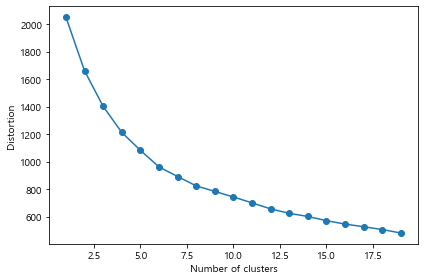

In [28]:
dist =[]
for i in range(1,20):
    k = KMeans(n_clusters=i,
          init='k-means++',
           n_init=10,
           max_iter=300,
           random_state=0)
    k.fit(total_sd)
    dist.append(k.inertia_)

plt.plot(range(1,20),dist, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

## 군집화

In [29]:
np.random.seed(1234)

In [30]:
total_sd_arr = total_sd.values

#k값을 5로 설정 후 k-means에 적용시키기
kmeans = KMeans(n_clusters =5,random_state=2021).fit(total_sd_arr)
kmeans.cluster_centers_


array([[-0.36921715, -0.05451903, -0.20395041, -0.06727131, -0.45900695,
         2.65618144,  1.887308  ],
       [ 0.40906073,  0.54561507,  0.17573195,  0.10170778,  1.09065539,
        -0.48461749, -0.57814846],
       [ 0.40906073,  0.57603661,  0.26461834,  0.00879425, -0.68758403,
        -0.04781717,  0.08547165],
       [ 0.40906073, -1.73600076,  0.0388374 , -0.08488709, -0.04050922,
        -0.29064038, -0.23267369],
       [-2.44462481, -0.38731229, -1.095228  , -0.07973221,  0.09814967,
        -0.04494856,  0.14038687]])

In [31]:
total_sd['cluster'] = kmeans.labels_
total_sd

,0,1,2,3,4,5,6,cluster
개포고등학교,0.409061,0.576037,0.549747,0.014073,-0.844731,2.656181,1.887308,0
경기고등학교,0.409061,-1.736001,0.549747,-0.767403,0.569590,2.656181,1.887308,0
경기여자고등학교,0.409061,0.576037,0.549747,-0.605672,-0.844731,2.656181,1.887308,0
국립국악고등학교,-2.444625,-1.736001,-1.819017,-0.546551,0.569590,2.656181,1.887308,0
단국대학교부속소프트웨어고등학교,-2.444625,0.576037,-1.819017,-0.265899,-0.844731,2.656181,1.887308,0
...,...,...,...,...,...,...,...,...
무학여자고등학교,0.409061,0.576037,0.549747,-0.424573,0.569590,0.751136,-1.555691,1
서울방송고등학교,0.409061,0.576037,0.549747,-0.987576,0.569590,0.751136,-1.555691,1
성수고등학교,0.409061,0.576037,0.549747,0.096298,-0.844731,0.751136,-1.555691,2
성수공업고등학교,0.409061,-1.736001,0.549747,-0.243814,0.569590,0.751136,-1.555691,3


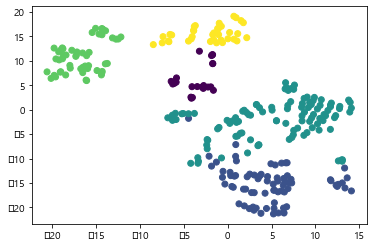

In [32]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100)
transformed = model.fit_transform(total_sd.iloc[:,:7])

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys,c=kmeans.labels_)

plt.show()

#군집별로 잘 구분이 된 것을 알 수 있다.

In [33]:
total_sd.reset_index(inplace=True)
total_sd.rename(columns={'index':'학교명',0:'내부상담_실시여부',1:'외부상담_실시여부',2:'wee클래스_운영여부',3:'학교폭력_예방교육_평균교육시간(1학급당)',4:'500미터내_파출소개수',5:'방범용CCTV',6:'어린이보호구역CCTV'},inplace=True)

In [34]:
total_sd

,학교명,내부상담_실시여부,외부상담_실시여부,wee클래스_운영여부,학교폭력_예방교육_평균교육시간(1학급당),500미터내_파출소개수,방범용CCTV,어린이보호구역CCTV,cluster
0,개포고등학교,0.409061,0.576037,0.549747,0.014073,-0.844731,2.656181,1.887308,0
1,경기고등학교,0.409061,-1.736001,0.549747,-0.767403,0.569590,2.656181,1.887308,0
2,경기여자고등학교,0.409061,0.576037,0.549747,-0.605672,-0.844731,2.656181,1.887308,0
3,국립국악고등학교,-2.444625,-1.736001,-1.819017,-0.546551,0.569590,2.656181,1.887308,0
4,단국대학교부속소프트웨어고등학교,-2.444625,0.576037,-1.819017,-0.265899,-0.844731,2.656181,1.887308,0
...,...,...,...,...,...,...,...,...,...
288,무학여자고등학교,0.409061,0.576037,0.549747,-0.424573,0.569590,0.751136,-1.555691,1
289,서울방송고등학교,0.409061,0.576037,0.549747,-0.987576,0.569590,0.751136,-1.555691,1
290,성수고등학교,0.409061,0.576037,0.549747,0.096298,-0.844731,0.751136,-1.555691,2
291,성수공업고등학교,0.409061,-1.736001,0.549747,-0.243814,0.569590,0.751136,-1.555691,3


In [35]:
total_sd['cluster'].value_counts()

2    108
1     76
3     51
4     36
0     22
Name: cluster, dtype: int64

In [36]:
final = pd.merge(total_sd,school_info,on='학교명',how='left')
final.head()

,학교명,내부상담_실시여부,외부상담_실시여부,wee클래스_운영여부,학교폭력_예방교육_평균교육시간(1학급당),500미터내_파출소개수,방범용CCTV,어린이보호구역CCTV,cluster,학교코드
0,개포고등학교,0.409061,0.576037,0.549747,0.014073,-0.844731,2.656181,1.887308,0,S010000373
1,경기고등학교,0.409061,-1.736001,0.549747,-0.767403,0.569590,2.656181,1.887308,0,S010000375
2,경기여자고등학교,0.409061,0.576037,0.549747,-0.605672,-0.844731,2.656181,1.887308,0,S010000376
3,국립국악고등학교,-2.444625,-1.736001,-1.819017,-0.546551,0.569590,2.656181,1.887308,0,S000003540
4,단국대학교부속소프트웨어고등학교,-2.444625,0.576037,-1.819017,-0.265899,-0.844731,2.656181,1.887308,0,S010000581


In [37]:
final.groupby('cluster').mean()

,내부상담_실시여부,외부상담_실시여부,wee클래스_운영여부,학교폭력_예방교육_평균교육시간(1학급당),500미터내_파출소개수,방범용CCTV,어린이보호구역CCTV
cluster,,,,,,,
0,-0.369217,-0.054519,-0.203950,-0.067271,-0.459007,2.656181,1.887308
1,0.409061,0.545615,0.175732,0.101708,1.090655,-0.484617,-0.578148
2,0.409061,0.576037,0.264618,0.008794,-0.687584,-0.047817,0.085472
3,0.409061,-1.736001,0.038837,-0.084887,-0.040509,-0.290640,-0.232674
4,-2.444625,-0.387312,-1.095228,-0.079732,0.098150,-0.044949,0.140387
